## Importing required libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import glob
import cv2
from albumentations import *
from tqdm import tqdm_notebook as tqdm
import gc
import tensorflow as tf
from tensorflow.keras.models import Model as KerasModel
from tensorflow.keras.layers import Input,Average,Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.optimizers import Adam
import face_recognition
import imageio
#from keras.models import Model, Input

Using TensorFlow backend.


## Generating image tensors with augmentations

In [2]:
train_df1=pd.read_csv('/scratch/cmpe295-guzun/deepfake/dfdc/train/train_df.csv')

In [3]:
from keras_preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1./255,
        zoom_range=0.2,
        rotation_range=15,
        brightness_range=(0.8, 1.2),
        channel_shift_range=30,
        horizontal_flip=True)

In [4]:
train_generator=train_datagen.flow_from_dataframe(
                            dataframe=train_df1,
                            directory= '/scratch/cmpe295-guzun/deepfake/dfdc/train/save_train_frames/',
                            x_col= 'file',
                            y_col= 'label',
                            shuffle=False,
                            batch_size=1,
                            class_mode="other")

Found 178446 validated image filenames.


In [5]:
X,y=next(train_generator)
X[0,:,:,:].shape

(256, 256, 3)

In [6]:
input_shape = X[0,:,:,:].shape
model_input = Input(shape=input_shape)

In [7]:
val_df=pd.read_csv('/scratch/cmpe295-guzun/deepfake/dfdc/train/val_df.csv')

In [9]:
val_generator=train_datagen.flow_from_dataframe(
                            dataframe=val_df,
                            directory= '/scratch/cmpe295-guzun/deepfake/dfdc/train/save_valid_frames/',
                            x_col= 'file',
                            y_col= 'label',
                            batch_size=1,
                            shuffle=False,
                            class_mode="other")

Found 44617 validated image filenames.


## Loading saved models for ensemble network

In [10]:
classifier1=tf.keras.models.load_model('/scratch/cmpe295-guzun/deepfake/dfdc/train/model/Meso4_12ktrained-model-val2')
classifier2=tf.keras.models.load_model('/scratch/cmpe295-guzun/deepfake/dfdc/train/model/MesoI_12ktrained-model-val')
models=[classifier1,classifier2]

2021-12-03 11:56:37.124897: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-03 11:56:37.176697: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2000020000 Hz
2021-12-03 11:56:37.185124: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x561033201000 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-12-03 11:56:37.185181: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [11]:
def ensemble(models):
    input_img = Input(shape=input_shape)

    outputs = [model(input_img) for model in models] # get the output of model given the input image
    y = Average()(outputs)

    model = KerasModel(inputs=input_img, outputs=y, name='ensemble')
    return model

In [12]:
ensemble_model = ensemble(models)

In [13]:
def evaluate_model(model,generator,df):
    Predict=[]
    vidname=[]
    y = []
    generator.reset()
    for i,(x_val_gen, y_val_gen) in enumerate(generator):
        Predict.append(model.predict(x_val_gen))
        vidname.append(generator.filenames[i])
        y.append(y_val_gen)
        if i >= len(df)-1:
            break
    return Predict,vidname,y

## Predicting ensemble performance on val set

In [14]:
Predict_e,vidname_e,y_e=evaluate_model(ensemble_model,val_generator,val_df)

In [15]:
pred_results_e=[]
for i in range(len(Predict_e)):
    pred_results_e.append([vidname_e[i].rstrip(".1234567890jpg")+"p4",y_e[i][0], Predict_e[i][0][0]])

In [18]:
pred_results_e

[['idsupeszcp.mp4', 0, 0.6797918],
 ['idsupeszcp.mp4', 0, 0.77850676],
 ['idsupeszcp.mp4', 0, 0.45218885],
 ['idsupeszcp.mp4', 0, 0.7930676],
 ['idsupeszcp.mp4', 0, 0.5375912],
 ['idsupeszcp.mp4', 0, 0.53755546],
 ['idsupeszcp.mp4', 0, 0.5766597],
 ['idsupeszcp.mp4', 0, 0.800454],
 ['idsupeszcp.mp4', 0, 0.72719043],
 ['idsupeszcp.mp4', 0, 0.43295634],
 ['idsupeszcp.mp4', 0, 0.9503598],
 ['idsupeszcp.mp4', 0, 0.96732205],
 ['idsupeszcp.mp4', 0, 0.61132586],
 ['idsupeszcp.mp4', 0, 0.28871828],
 ['ohvhsopjko.mp4', 0, 0.0014412254],
 ['ohvhsopjko.mp4', 0, 0.001230821],
 ['ohvhsopjko.mp4', 0, 0.033663556],
 ['ohvhsopjko.mp4', 0, 0.22133777],
 ['ohvhsopjko.mp4', 0, 0.07715039],
 ['ohvhsopjko.mp4', 0, 0.30729458],
 ['ohvhsopjko.mp4', 0, 0.22063495],
 ['ohvhsopjko.mp4', 0, 0.0061649233],
 ['ohvhsopjko.mp4', 0, 0.04139848],
 ['ohvhsopjko.mp4', 0, 0.17117837],
 ['ohvhsopjko.mp4', 0, 0.1640132],
 ['ohvhsopjko.mp4', 0, 0.13991909],
 ['ohvhsopjko.mp4', 0, 0.092401564],
 ['ohvhsopjko.mp4', 0, 0.0368

In [16]:
df_e = pd.DataFrame(pred_results_e, columns=["Filenames","Original","Predicted"])
df_e.head()

,Filenames,Original,Predicted
0,idsupeszcp.mp4,0,0.679792
1,idsupeszcp.mp4,0,0.778507
2,idsupeszcp.mp4,0,0.452189
3,idsupeszcp.mp4,0,0.793068
4,idsupeszcp.mp4,0,0.537591


In [17]:
pred_df_e = pd.DataFrame(df_e.groupby(['Filenames']).mean())  #aggregate frames belonging to same video
pred_df_e.reset_index()

,Filenames,Original,Predicted
0,aacfuwiwjw.mp4,1,0.552008
1,aajxdztmpb.mp4,1,0.587497
2,aanvfngndg.mp4,1,0.585458
3,abahildqna.mp4,0,0.716726
4,abhggqdift.mp4,0,0.153997
...,...,...,...
3188,zzhtdtgdur.mp4,1,0.677490
3189,zznanrtksj.mp4,0,0.269161
3190,zzogukbedf.mp4,0,0.378249
3191,zzsvsjkcva.mp4,0,0.407938


In [21]:
pred_df_e.loc[pred_df_e['Predicted'] > 0.5, 'Predicted'] = 1   #change prediction results depending on the threshold
pred_df_e.loc[pred_df_e['Predicted'] < 0.5, 'Predicted'] = 0
len(pred_df_e)

3193

In [22]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
target_names = ['Fake', 'Real']
print(classification_report(pred_df_e.Original.values, pred_df_e.Predicted.values, target_names=target_names))

              precision    recall  f1-score   support

        Fake       0.71      0.82      0.76      1586
        Real       0.79      0.67      0.72      1607

    accuracy                           0.74      3193
   macro avg       0.75      0.74      0.74      3193
weighted avg       0.75      0.74      0.74      3193



## Generating image tensors for test frames

In [25]:
test_df=pd.read_csv('/scratch/cmpe295-guzun/deepfake/dfdc/test/test_df_new.csv')
test_df.head()

,file,label
0,hninolobbi.mp410.jpg,0
1,hninolobbi.mp420.jpg,0
2,hninolobbi.mp430.jpg,0
3,hninolobbi.mp440.jpg,0
4,hninolobbi.mp450.jpg,0


In [26]:
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_dataframe(
                            dataframe=test_df,
                            directory= '/scratch/cmpe295-guzun/deepfake/dfdc/test/save_test_frames2/',
                            x_col= 'file',
                            y_col= 'label',
                            batch_size=1,
                            class_mode="other", shuffle=False)

Found 66493 validated image filenames.


## Predicting ensemble performance on test frames

In [27]:
Predict_test,vidname_test,y_test=evaluate_model(ensemble_model,test_generator,test_df)

In [28]:
test_preds=[]
for i in range(len(Predict_test)):
    test_preds.append([vidname_test[i].rstrip(".1234567890jpg")+"p4",y_test[i][0], Predict_test[i][0][0]])

In [29]:
test_pred_df = pd.DataFrame(test_preds, columns=["Filenames","Original","Predicted"])

In [30]:
test_df_grp = pd.DataFrame(test_pred_df.groupby(['Filenames']).mean()) #aggregate frames belonging to same video
test_df_grp.reset_index()

,Filenames,Original,Predicted
0,aalscayrfi.mp4,1,0.771223
1,aalyqplqns.mp4,1,0.750450
2,aamrozxzsq.mp4,0,0.379949
3,aaoqanfmgd.mp4,0,0.235839
4,aarpyivfys.mp4,1,0.631282
...,...,...,...
4763,zzoqoqsqtf.mp4,0,0.522438
4764,zzrglepohd.mp4,0,0.804659
4765,zztotvpkjc.mp4,1,0.695640
4766,zztsycpujv.mp4,0,0.421113


In [31]:
test_df_grp.loc[test_df_grp['Predicted'] > 0.5, 'Predicted'] = 1   #change prediction results depending on the threshold
test_df_grp.loc[test_df_grp['Predicted'] < 0.5, 'Predicted'] = 0
test_df_grp.head()

,Original,Predicted
Filenames,,
aalscayrfi.mp4,1,1.0
aalyqplqns.mp4,1,1.0
aamrozxzsq.mp4,0,0.0
aaoqanfmgd.mp4,0,0.0
aarpyivfys.mp4,1,1.0


In [32]:
print(classification_report(test_df_grp.Original.values, test_df_grp.Predicted.values, target_names=target_names))

              precision    recall  f1-score   support

        Fake       0.57      0.60      0.58      2403
        Real       0.57      0.53      0.55      2365

    accuracy                           0.57      4768
   macro avg       0.57      0.57      0.57      4768
weighted avg       0.57      0.57      0.57      4768



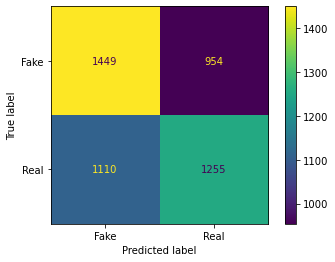

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(test_df_grp.Original.values, test_df_grp.Predicted.values)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=target_names)
disp.plot()
plt.show()

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test_df_grp.Original.values,test_df_grp.Predicted.values)

In [35]:
roc_auc

0.5668258229010776